In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [ ]:
# –∑–∞–¥–∞–µ–º –ø—É—Ç–∏ –∫ —Ä–∞–∑–∞—Ä—Ö–∏–≤–∏—Ä–æ–≤–∞–Ω–Ω—ã–º –¥–∞–Ω–Ω—ã–º
data_path = '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1'
train_dir = os.path.join(data_path, 'Train')
val_dir = os.path.join(data_path, 'Test')
meta_dir = os.path.join(data_path, 'Meta')
%ls /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train

0/   11/  14/  17/  2/   22/  25/  28/  30/  33/  36/  39/  41/  6/  9/
1/   12/  15/  18/  20/  23/  26/  29/  31/  34/  37/  4/   42/  7/
10/  13/  16/  19/  21/  24/  27/  3/   32/  35/  38/  40/  5/   8/


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# –ü—É—Ç—å –∫ –∏—Å—Ö–æ–¥–Ω–æ–π –ø–∞–ø–∫–µ —Å –¥–∞–Ω–Ω—ã–º–∏
source_dir = train_dir  # –ü–∞–ø–∫–∞ —Å –∏—Å—Ö–æ–¥–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏, —Ä–∞–∑–±–∏—Ç—ã–º–∏ –ø–æ –∫–ª–∞—Å—Å–∞–º
output_dir = os.path.join(data_path, 'ProcessedData')  # –ü–∞–ø–∫–∞ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–∞–∑–¥–µ–ª–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö

# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫–∏ –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –∏ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
test_size = 0.2  # –î–æ–ª—è –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–≥–æ –Ω–∞–±–æ—Ä–∞

# –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Å—É
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)

    # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ —ç—Ç–æ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏—è
    if os.path.isdir(class_path):
        # –°–æ–∑–¥–∞–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –ø–∞–ø–∫–∏ –¥–ª—è –∫–ª–∞—Å—Å–∞ –≤ train –∏ test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # –ü–æ–ª—É—á–∞–µ–º —Å–ø–∏—Å–æ–∫ –≤—Å–µ—Ö —Ñ–∞–π–ª–æ–≤ –≤ –∫–ª–∞—Å—Å–µ
        files = os.listdir(class_path)
        files = [f for f in files if os.path.isfile(os.path.join(class_path, f))]

        # –†–∞–∑–¥–µ–ª—è–µ–º —Ñ–∞–π–ª—ã –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –∏ —Ç–µ—Å—Ç–æ–≤—ã–µ
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # –ö–æ–ø–∏—Ä—É–µ–º —Ñ–∞–π–ª—ã –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –ø–∞–ø–∫–∏
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print(f"–î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Ä–∞–∑–¥–µ–ª–µ–Ω—ã. –¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ: {train_dir}, –¢–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ: {test_dir}")


–î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Ä–∞–∑–¥–µ–ª–µ–Ω—ã. –¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/train, –¢–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/ProcessedData/test


In [ ]:
IMG_SIZE = (224, 224)  # ResNet50 –æ–∂–∏–¥–∞–µ—Ç 224x224 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
BATCH_SIZE = 32
NUM_CLASSES = 43  # GTSRB —Å–æ–¥–µ—Ä–∂–∏—Ç 43 –∫–ª–∞—Å—Å–∞
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏—Ö —Å–ª–æ–µ–≤
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π –ø–ª–æ—Ç–Ω—ã–π —Å–ª–æ–π
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. "–ó–∞–º–æ—Ä–æ–∑–∫–∞" –±–∞–∑–æ–≤–æ–π –º–æ–¥–µ–ª–∏ –¥–ª—è –ø—Ä–µ–¥–æ—Ç–≤—Ä–∞—â–µ–Ω–∏—è –∏–∑–º–µ–Ω–µ–Ω–∏—è –≤–µ—Å–æ–≤ –≤–æ –≤—Ä–µ–º—è –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è
for layer in base_model.layers:
    layer.trainable = False

# 5. –ö–æ–º–ø–∏–ª—è—Ü–∏—è –º–æ–¥–µ–ª–∏
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# 7. –†–∞–∑–º–æ—Ä–æ–∑–∫–∞ –∏ –¥–æ–æ–±—É—á–µ–Ω–∏–µ
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)
save_model(model, 'ResNet50.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 340s 414ms/step - accuracy: 0.0767 - loss: 3.4676 - val_accuracy: 0.1439 - val_loss: 3.2432
Epoch 2/10
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363s 397ms/step - accuracy: 0.1299 - loss: 3.2320 - val_accuracy: 0.1761 - val_loss: 3.0930
Epoch 3/10
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 328s 405ms/step - accuracy: 0.1818 - loss: 3.0201 - val_accuracy: 0.1445 - val_loss: 3.0081
Epoch 4/10
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 316s 398ms/step - accuracy: 0.2039 - loss: 2.8927 - val_accuracy: 0.1981 - val_loss: 2.9030
Epoch 5/10
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 317s 401ms/step - accuracy: 0.2280 - loss: 2.7980 - val_accuracy: 0.1903 - val_loss: 2.8806
Epoch 6/10
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 316s 399ms/step - accuracy: 0.2328 - loss: 2.7373 - val_accuracy: 0.227

In [ ]:
# –°–æ–∑–¥–∞–Ω–∏–µ –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–æ–≤ –¥–∞–Ω–Ω—ã—Ö —Å –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–µ–π
train2_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train2_generator = train2_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val2_generator = train2_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏ VGG16
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å—Å–∫–∏—Ö —Å–ª–æ–µ–≤
x = base_model2.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # –ü–µ—Ä–≤—ã–π –ø–ª–æ—Ç–Ω—ã–π —Å–ª–æ–π
x = Dropout(0.5)(x)  # Dropout –¥–ª—è —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏
x = Dense(256, activation='relu')(x)  # –í—Ç–æ—Ä–æ–π –ø–ª–æ—Ç–Ω—ã–π —Å–ª–æ–π
x = Dropout(0.5)(x)  # Dropout –¥–ª—è —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # –í—ã—Ö–æ–¥–Ω–æ–π —Å–ª–æ–π —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –∫–ª–∞—Å—Å–æ–≤ GTSRB

model2 = Model(inputs=base_model2.input, outputs=predictions)

# 4. –ó–∞–º–æ—Ä–æ–∑–∫–∞ –±–∞–∑–æ–≤—ã—Ö —Å–ª–æ–µ–≤
for layer in base_model.layers:
    layer.trainable = False

# 5. –ö–æ–º–ø–∏–ª—è—Ü–∏—è –º–æ–¥–µ–ª–∏
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
history = model2.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 7. –†–∞–∑–º–æ—Ä–æ–∑–∫–∞ –∏ –¥–æ–æ–±—É—á–µ–Ω–∏–µ
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train2_generator,
    epochs=5,
    validation_data=val2_generator
)

# 8. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model.save('vgg16.h5')

Found 25110 images belonging to 43 classes.
Found 1550 images belonging to 43 classes.
Epoch 1/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 467s 582ms/step - accuracy: 0.0491 - loss: 3.7180 - val_accuracy: 0.0581 - val_loss: 3.4801
Epoch 2/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 473s 549ms/step - accuracy: 0.0531 - loss: 3.4963 - val_accuracy: 0.0555 - val_loss: 3.4813
Epoch 3/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 440s 547ms/step - accuracy: 0.0535 - loss: 3.4919 - val_accuracy: 0.0555 - val_loss: 3.4798
Epoch 4/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 436s 552ms/step - accuracy: 0.0544 - loss: 3.4934 - val_accuracy: 0.0581 - val_loss: 3.4795
Epoch 5/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 439s 548ms/step - accuracy: 0.0555 - loss: 3.4986 - val_accuracy: 0.0542 - val_loss: 3.4782
Epoch 1/5
785/785 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

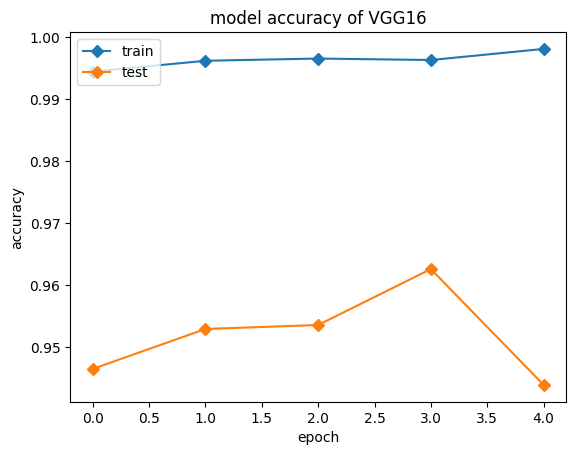

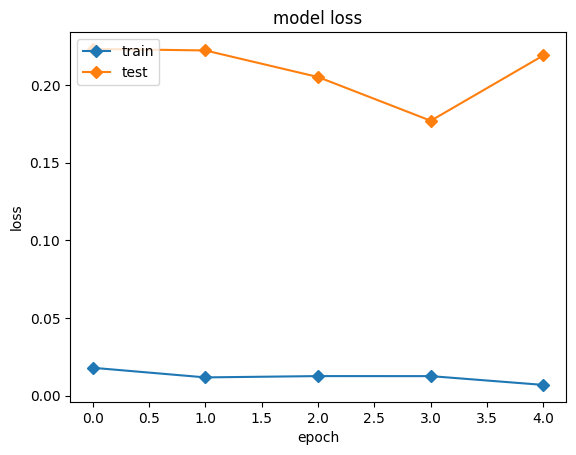

In [ ]:
plt.plot(history_fine_tune.history['accuracy'], marker='D')
plt.plot(history_fine_tune.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# –≥—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.plot(history_fine_tune.history['loss'], marker='D')
plt.plot(history_fine_tune.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
model_attack = tf.keras.models.load_model('/content/drive/MyDrive/ResNet50.h5')
tf.compat.v1.enable_eager_execution()
print("Eager Execution:", tf.executing_eagerly())
IMG_SIZE = (224, 224)
test_dir = os.path.join(output_dir, 'test')

# –°–æ–∑–¥–∞–µ–º –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=50,  # –ó–∞–≥—Ä—É–∑–∏–º –≤—Å–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –∞—Ç–∞–∫–∏
    class_mode='categorical',
    shuffle=False
)

# –ò–∑–≤–ª–µ–∫–∞–µ–º –¥–∞–Ω–Ω—ã–µ –∏ –º–µ—Ç–∫–∏
x_test, y_test = next(test_generator)
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

def predict_fn(x, training=False):
    return model_attack(x, training=False)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)  # –§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å

classifier = TensorFlowV2Classifier(
    model=predict_fn,
    nb_classes=43,  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤ GTSRB
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object  # –ü–µ—Ä–µ–¥–∞—á–∞ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å
)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

results = []
for eps in eps_range:
    print(f"–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps={eps:.6f}...")

    # –°–æ–∑–¥–∞–Ω–∏–µ FGSM –∞—Ç–∞–∫–∏ —Å —Ç–µ–∫—É—â–∏–º eps
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    x_test_adv = attack.generate(x=x_test)

    # –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
    results.append({'eps': eps, 'accuracy': accuracy})

print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∞—Ç–∞–∫:")
for result in results:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Eager Execution: True
Found 7842 images belonging to 43 classes.
x_test shape: (50, 224, 224, 3)
y_test shape: (50, 43)
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.003922...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.003922): 62.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.007843...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.007843): 66.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.011765...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.011765): 64.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.015686...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.015686): 62.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.019608...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.019608): 62.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=0.031373...
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.031373): 52.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è –∞—Ç–∞–∫–∞ FGSM —Å eps=

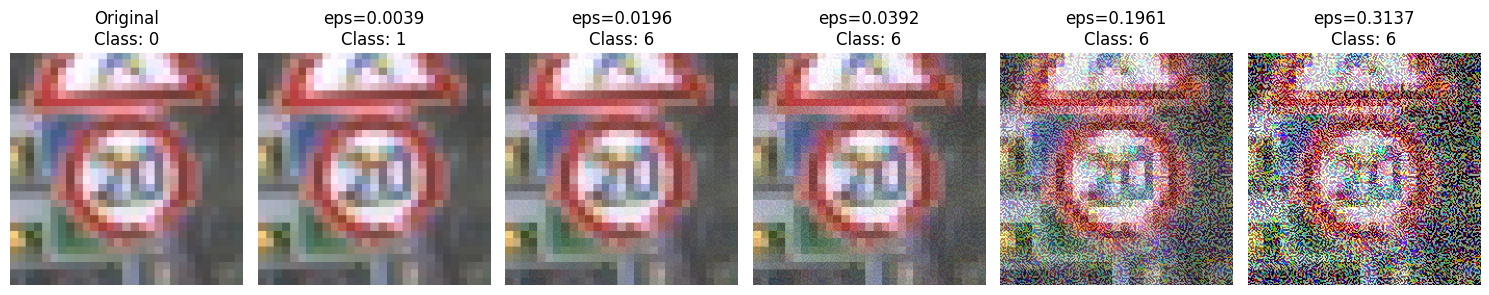

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
sample_index = 0  # –ò–Ω–¥–µ–∫—Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –¥–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏
original_image = x_test[sample_index]
original_label = np.argmax(y_test[sample_index])
# 3. –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
attacked_images = []
predicted_classes = []

for eps in eps_values:
    # –°–æ–∑–¥–∞–Ω–∏–µ FGSM –∞—Ç–∞–∫–∏
    attack = FastGradientMethod(estimator=classifier, eps=eps)

    # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω–æ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    attacked_image = attack.generate(x=original_image.reshape(1, *original_image.shape))[0]
    attacked_images.append(attacked_image)

    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –∫–ª–∞—Å—Å–∞
    prediction = classifier.predict(attacked_image.reshape(1, *attacked_image.shape))
    predicted_class = np.argmax(prediction)
    predicted_classes.append(predicted_class)

# 4. –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(15, 10))

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {original_label}")
plt.axis("off")

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π
for i, eps in enumerate(eps_values):
    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_images[i])
    plt.title(f"eps={eps:.4f}\nClass: {predicted_classes[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.003922): 18.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.007843...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.007843): 2.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.011765...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.011765): 2.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.015686...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.015686): 2.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.019608): 0.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.031373...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.031373): 0.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.039216): 2.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.078431...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.078431): 0.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.196078): 0.00%
–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps=0.313725): 0.00%


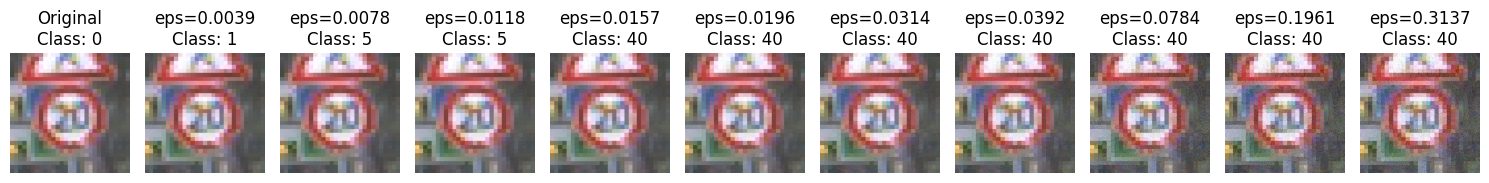


–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∞—Ç–∞–∫:
eps=0.003922, accuracy=18.00%
eps=0.007843, accuracy=2.00%
eps=0.011765, accuracy=2.00%
eps=0.015686, accuracy=2.00%
eps=0.019608, accuracy=0.00%
eps=0.031373, accuracy=0.00%
eps=0.039216, accuracy=2.00%
eps=0.078431, accuracy=0.00%
eps=0.196078, accuracy=0.00%
eps=0.313725, accuracy=0.00%


In [ ]:
eps_values = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
eps_step = 2 / 255  # –®–∞–≥ –∏–∑–º–µ–Ω–µ–Ω–∏—è –∑–∞ –∏—Ç–µ—Ä–∞—Ü–∏—é
max_iter = 40  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏—Ç–µ—Ä–∞—Ü–∏–π

# –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ PGD –∞—Ç–∞–∫ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ eps
results2 = []
attacked_images_per_eps2 = {}

for eps in eps_values:
    print(f"–í—ã–ø–æ–ª–Ω—è–µ—Ç—Å—è PGD –∞—Ç–∞–∫–∞ —Å eps={eps:.6f}...")

    # –°–æ–∑–¥–∞–Ω–∏–µ PGD –∞—Ç–∞–∫–∏
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=eps,
        eps_step=eps_step,
        max_iter=max_iter,
        targeted=False
    )

    # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    x_test_adv = attack.generate(x=x_test)
    attacked_images_per_eps2[eps] = x_test_adv  # –°–æ—Ö—Ä–∞–Ω—è–µ–º –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è

    # –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    predictions = classifier.predict(x_test_adv, batch_size=50)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print(f"–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö (eps={eps:.6f}): {accuracy * 100:.2f}%")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
    results2.append({'eps': eps, 'accuracy': accuracy})

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–ª—è –æ—Ç–¥–µ–ª—å–Ω—ã—Ö eps
sample_index = 0  # –ò–Ω–¥–µ–∫—Å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –¥–ª—è –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏–∏
original_image = x_test[sample_index]

plt.figure(figsize=(15, 10))

# –ò—Å—Ö–æ–¥–Ω–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
plt.subplot(1, len(eps_values) + 1, 1)
plt.imshow(original_image)
plt.title(f"Original\nClass: {np.argmax(y_test[sample_index])}")
plt.axis("off")

# –ê—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
for i, eps in enumerate(eps_values):
    attacked_image = attacked_images_per_eps2[eps][sample_index]
    attacked_prediction = np.argmax(classifier.predict(attacked_image.reshape(1, *attacked_image.shape)))

    plt.subplot(1, len(eps_values) + 1, i + 2)
    plt.imshow(attacked_image)
    plt.title(f"eps={eps:.4f}\nClass: {attacked_prediction}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∞—Ç–∞–∫:")
for result in results2:
    print(f"eps={result['eps']:.6f}, accuracy={result['accuracy'] * 100:.2f}%")

Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 62.00%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 62.00%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 44.00%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 20.00%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 2.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120598 (\N{MATHEMATICAL ITALIC EPSILON SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


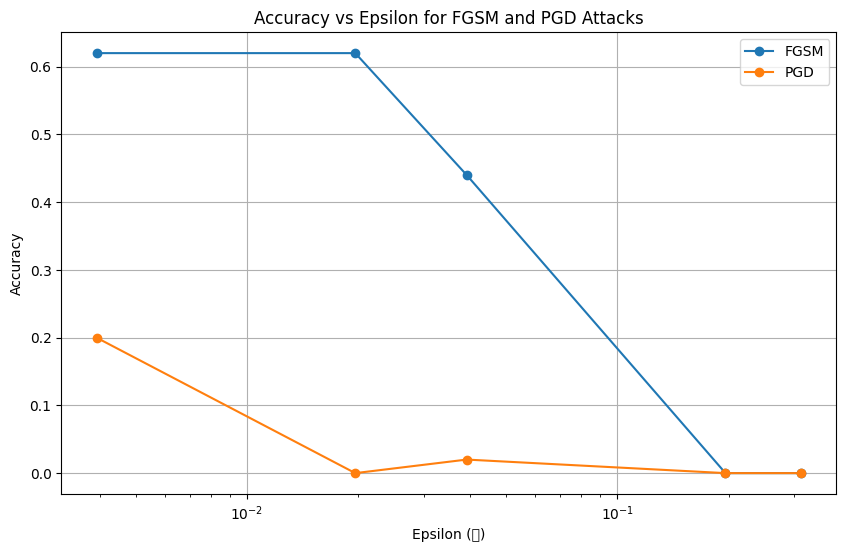

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results = {"FGSM": [], "PGD": []}

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∞—Ç–∞–∫–∏ –∏ –æ—Ü–µ–Ω–∫–∏ —Ç–æ—á–Ω–æ—Å—Ç–∏
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # –û–±–Ω–æ–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä eps –¥–ª—è –∞—Ç–∞–∫–∏
        attack_object.set_params(eps=eps)

        # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
        x_test_adv = attack_object.generate(x=x_test)

        # –û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏
        predictions = classifier.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.0)  # eps –±—É–¥–µ—Ç –∏–∑–º–µ–Ω—è—Ç—å—Å—è –≤ —Ü–∏–∫–ª–µ
pgd_attack = ProjectedGradientDescent(
    estimator=classifier,
    norm=np.inf,
    eps=0.0,  # eps –±—É–¥–µ—Ç –∏–∑–º–µ–Ω—è—Ç—å—Å—è –≤ —Ü–∏–∫–ª–µ
    eps_step=2/255,
    max_iter=40,
    targeted=False
)
# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –¥–ª—è FGSM
accuracy_results["FGSM"] = evaluate_attack("FGSM", fgsm_attack, x_test, y_test)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –¥–ª—è PGD
accuracy_results["PGD"] = evaluate_attack("PGD", pgd_attack, x_test, y_test)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results["PGD"], marker='o', label='PGD')

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks')
plt.xlabel('Epsilon (ùúñ)')
plt.ylabel('Accuracy')
plt.xscale('log')  # –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–∞—è —à–∫–∞–ª–∞ –¥–ª—è eps
plt.grid(True)
plt.legend()

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.show()

Found 7842 images belonging to 43 classes.
Evaluating FGSM with eps=0.003922...
FGSM Accuracy at eps=0.003922: 27.50%
Evaluating FGSM with eps=0.019608...
FGSM Accuracy at eps=0.019608: 27.50%
Evaluating FGSM with eps=0.039216...
FGSM Accuracy at eps=0.039216: 52.50%
Evaluating FGSM with eps=0.196078...
FGSM Accuracy at eps=0.196078: 0.00%
Evaluating FGSM with eps=0.313725...
FGSM Accuracy at eps=0.313725: 0.00%
Evaluating PGD with eps=0.003922...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.003922: 5.00%
Evaluating PGD with eps=0.019608...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.019608: 0.00%
Evaluating PGD with eps=0.039216...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.039216: 0.00%
Evaluating PGD with eps=0.196078...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.196078: 0.00%
Evaluating PGD with eps=0.313725...


PGD - Batches: 0it [00:00, ?it/s]

PGD Accuracy at eps=0.313725: 0.00%


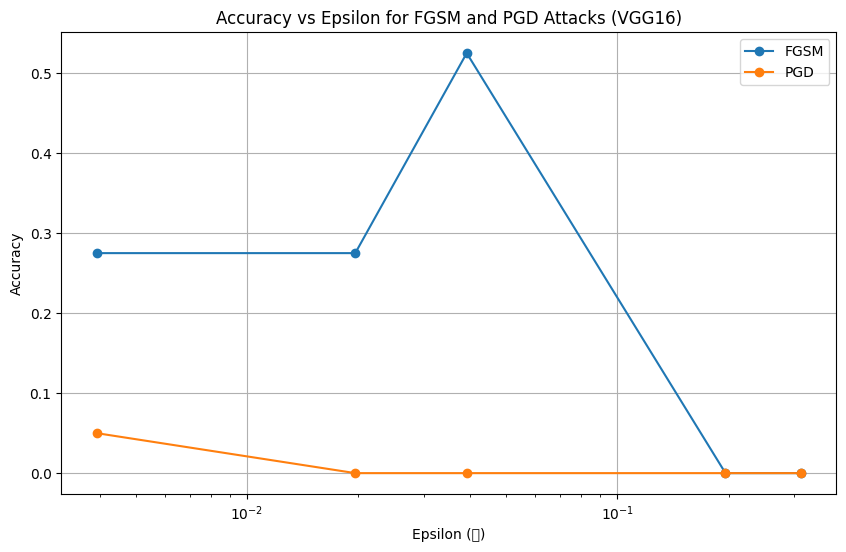

In [ ]:
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]
accuracy_results_vgg16 = {"FGSM": [], "PGD": []}

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∞—Ç–∞–∫–∏ –∏ –æ—Ü–µ–Ω–∫–∏ —Ç–æ—á–Ω–æ—Å—Ç–∏
def evaluate_attack(attack_name, attack_object, x_test, y_test):
    accuracies = []
    for eps in eps_values:
        print(f"Evaluating {attack_name} with eps={eps:.6f}...")

        # –û–±–Ω–æ–≤–ª—è–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä eps –¥–ª—è –∞—Ç–∞–∫–∏
        attack_object.set_params(eps=eps)

        # –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –∞—Ç–∞–∫–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
        x_test_adv = attack_object.generate(x=x_test)

        # –û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏
        predictions = classifier_vgg16.predict(x_test_adv, batch_size=16)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        print(f"{attack_name} Accuracy at eps={eps:.6f}: {accuracy * 100:.2f}%")
        accuracies.append(accuracy)
    return accuracies
model_vgg16 = tf.keras.models.load_model('/content/drive/MyDrive/vgg16.h5')

def predict_fn_vgg16(x, training=False):
    return model_vgg16(x, training=training)

loss_object_vgg16 = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
classifier_vgg16 = TensorFlowV2Classifier(
    model=predict_fn_vgg16,
    nb_classes=43,
    input_shape=(224, 224, 3),
    clip_values=(0, 1),
    loss_object=loss_object_vgg16
)

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

test_dir = os.path.join(output_dir, 'test')
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=40,
    class_mode='categorical',
    shuffle=False
)

x_test, y_test = next(test_generator)

# –°–æ–∑–¥–∞–Ω–∏–µ –∞—Ç–∞–∫
fgsm_attack_vgg16 = FastGradientMethod(estimator=classifier_vgg16, eps=0.0)  # eps –±—É–¥–µ—Ç –∏–∑–º–µ–Ω—è—Ç—å—Å—è –≤ —Ü–∏–∫–ª–µ
pgd_attack_vgg16 = ProjectedGradientDescent(
    estimator=classifier_vgg16,
    norm=np.inf,
    eps=0.0,  # eps –±—É–¥–µ—Ç –∏–∑–º–µ–Ω—è—Ç—å—Å—è –≤ —Ü–∏–∫–ª–µ
    eps_step=2/255,
    max_iter=40,
    targeted=False
)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ VGG16 –¥–ª—è FGSM
accuracy_results_vgg16["FGSM"] = evaluate_attack("FGSM", fgsm_attack_vgg16, x_test, y_test)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ VGG16 –¥–ª—è PGD
accuracy_results_vgg16["PGD"] = evaluate_attack("PGD", pgd_attack_vgg16, x_test, y_test)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(10, 6))

plt.plot(eps_values, accuracy_results_vgg16["FGSM"], marker='o', label='FGSM')
plt.plot(eps_values, accuracy_results_vgg16["PGD"], marker='o', label='PGD')

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –≥—Ä–∞—Ñ–∏–∫–∞
plt.title('Accuracy vs Epsilon for FGSM and PGD Attacks (VGG16)')
plt.xlabel('Epsilon (ùúñ)')
plt.ylabel('Accuracy')
plt.xscale('log')  # –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–∞—è —à–∫–∞–ª–∞ –¥–ª—è eps
plt.grid(True)
plt.legend()

# –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.show()

In [ ]:
import pandas as pd

# 1. –î–∞–Ω–Ω—ã–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ (–ø—Ä–∏–º–µ—Ä–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏–ª–∏ —Ä–µ–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è)
eps_values = [1/255, 5/255, 10/255, 50/255, 80/255]

# –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç–æ—á–Ω–æ—Å—Ç–∏ –¥–ª—è FGSM –∏ PGD –¥–ª—è –æ–±–µ–∏—Ö –º–æ–¥–µ–ª–µ–π
accuracy_vgg16_fgsm = accuracy_results_vgg16["FGSM"]
accuracy_vgg16_pgd = accuracy_results_vgg16["PGD"]

accuracy_resnet50_fgsm = accuracy_results["FGSM"]
accuracy_resnet50_pgd = accuracy_results["PGD"]

# 2. –°–æ–∑–¥–∞–Ω–∏–µ DataFrame
data = {
    "Epsilon (ùúñ)": eps_values,
    "VGG16 FGSM": accuracy_vgg16_fgsm,
    "VGG16 PGD": accuracy_vgg16_pgd,
    "ResNet50 FGSM": accuracy_resnet50_fgsm,
    "ResNet50 PGD": accuracy_resnet50_pgd
}

df = pd.DataFrame(data)

# 3. –í—ã–≤–æ–¥ —Ç–∞–±–ª–∏—Ü—ã
print("–¢–∞–±–ª–∏—Ü–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏:")
print(df)


–¢–∞–±–ª–∏—Ü–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏:
   Epsilon (ùúñ)  VGG16 FGSM  VGG16 PGD  ResNet50 FGSM  ResNet50 PGD
0     0.003922       0.275       0.05           0.62          0.20
1     0.019608       0.275       0.00           0.62          0.00
2     0.039216       0.525       0.00           0.44          0.02
3     0.196078       0.000       0.00           0.00          0.00
4     0.313725       0.000       0.00           0.00          0.00
